C:\Users\LEETJ\AppData\Local\Temp\ipykernel_2660\613564616.py:31: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='time')
c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2753/2753 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2753/2753 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step

2753/2753 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


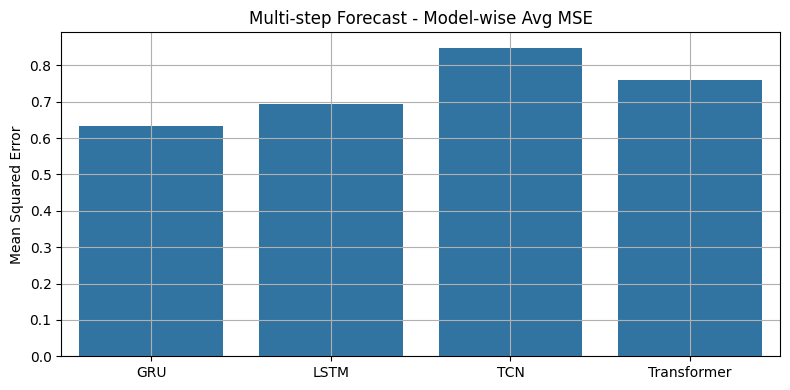

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, GRU, LSTM, Dropout, GlobalAveragePooling1D,
    LayerNormalization, MultiHeadAttention
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tcn import TCN

# 데이터 전처리
data = pd.read_csv("../frontend/public/sensor.csv")

all_zero_cols = data.columns[(data == 0).all()].tolist()
all_nan_cols = data.columns[data.isna().all()].tolist()
threshold = 1.2
low_std_cols = data.std(numeric_only=True).loc[lambda x: x < threshold].index.tolist()
useless_columns = list(set(all_zero_cols + all_nan_cols + low_std_cols))
data = data.drop(columns=useless_columns)

status_map = {'NORMAL': 0, 'RECOVERING': 1, 'BROKEN': 2}
data['machine_status_encoded'] = data['machine_status'].map(status_map)

data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)
data = data.interpolate(method='time')

sensor_cols = [col for col in data.columns if col.startswith('sensor')]
scaler = StandardScaler()
data[sensor_cols] = scaler.fit_transform(data[sensor_cols])

data = data.drop(columns=['machine_status'])
data = data.sort_index()

# 시계열 window 생성 (multi-step 예측)
def create_multistep_windows(sensor_data, input_steps=60, output_steps=60, step=1):
    X, y = [], []
    for i in range(0, len(sensor_data) - input_steps - output_steps, step):
        X.append(sensor_data[i:i+input_steps])
        y.append(sensor_data[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(y)

X_all, y_all = create_multistep_windows(data[sensor_cols].values, input_steps=60, output_steps=60)

split_index = int(len(X_all) * 0.6)
X_train, y_train = X_all[:split_index], y_all[:split_index]
X_test, y_test = X_all[split_index:], y_all[split_index:]

# 학습 데이터 축소
subset_size = int(len(X_train) * 0.1)
X_train_small, y_train_small = X_train[:subset_size], y_train[:subset_size]

# 공통 평가 함수
def evaluate_model(name, y_true, y_pred):
    return np.mean([
        mean_squared_error(y_true[:, :, i].flatten(), y_pred[:, :, i].flatten())
        for i in range(y_true.shape[2])
    ])

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# GRU
gru = Sequential([
    GRU(64, input_shape=X_train.shape[1:]),
    Dense(y_train.shape[1] * y_train.shape[2])
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train_small, y_train_small.reshape(subset_size, -1),
        validation_split=0.2, epochs=5, batch_size=64, verbose=0, callbacks=[early_stop])
y_pred_gru = gru.predict(X_test).reshape(-1, y_test.shape[1], y_test.shape[2])
mse_gru = evaluate_model('GRU', y_test, y_pred_gru)

# LSTM
lstm = Sequential([
    LSTM(64, input_shape=X_train.shape[1:]),
    Dense(y_train.shape[1] * y_train.shape[2])
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train_small, y_train_small.reshape(subset_size, -1),
         validation_split=0.2, epochs=5, batch_size=64, verbose=0, callbacks=[early_stop])
y_pred_lstm = lstm.predict(X_test).reshape(-1, y_test.shape[1], y_test.shape[2])
mse_lstm = evaluate_model('LSTM', y_test, y_pred_lstm)

# TCN
tcn = Sequential([
    Input(shape=X_train.shape[1:]),
    TCN(nb_filters=32, kernel_size=3, dilations=[1, 2, 4]),
    Dense(y_train.shape[1] * y_train.shape[2])
])
tcn.compile(optimizer=Adam(1e-3), loss='mse')
tcn.fit(X_train_small, y_train_small.reshape(subset_size, -1),
        validation_split=0.2, epochs=5, batch_size=64, verbose=0, callbacks=[early_stop])
y_pred_tcn = tcn.predict(X_test).reshape(-1, y_test.shape[1], y_test.shape[2])
mse_tcn = evaluate_model('TCN', y_test, y_pred_tcn)

# Transformer
def transformer_block(inputs, num_heads=2, ff_dim=64, dropout=0.1):
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn = Dropout(dropout)(attn)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn)
    ff = Dense(ff_dim, activation='relu')(out1)
    ff = Dense(inputs.shape[-1])(ff)
    return LayerNormalization(epsilon=1e-6)(out1 + ff)

inputs = Input(shape=X_train.shape[1:])
x = transformer_block(inputs)
x = GlobalAveragePooling1D()(x)
outputs = Dense(y_train.shape[1] * y_train.shape[2])(x)
transformer = Model(inputs, outputs)
transformer.compile(optimizer='adam', loss='mse')
transformer.fit(X_train_small, y_train_small.reshape(subset_size, -1),
                validation_split=0.2, epochs=5, batch_size=64, verbose=0, callbacks=[early_stop])
y_pred_trans = transformer.predict(X_test).reshape(-1, y_test.shape[1], y_test.shape[2])
mse_trans = evaluate_model('Transformer', y_test, y_pred_trans)

# 결과 시각화
model_names = ['GRU', 'LSTM', 'TCN', 'Transformer']
mse_values = [mse_gru, mse_lstm, mse_tcn, mse_trans]

plt.figure(figsize=(8, 4))
sns.barplot(x=model_names, y=mse_values)
plt.title("Multi-step Forecast - Model-wise Avg MSE")
plt.ylabel("Mean Squared Error")
plt.tight_layout()
plt.grid(True)
plt.show()


C:\Users\LEETJ\AppData\Local\Temp\ipykernel_2660\3329063703.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='time')
c:\Users\LEETJ\Desktop\SKKU-SFP\backend\tfenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 0.2116 - val_loss: 0.2172
Epoch 2/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0168 - val_loss: 0.1176
Epoch 3/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0097 - val_loss: 0.0763
Epoch 4/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0072 - val_loss: 0.0656
Epoch 5/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0068 - val_loss: 0.0601
Epoch 6/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0062 - val_loss: 0.0570
Epoch 7/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0061 - val_loss: 0.0552
Epoch 8/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 0.0057 - val_loss: 0.0533
Epoch 9/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0057 - val_loss: 0.0522
Epoch 10/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0057 - val_loss: 0.0530
Epoch 11/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0058 - val_loss: 0.0511
Epoch 12

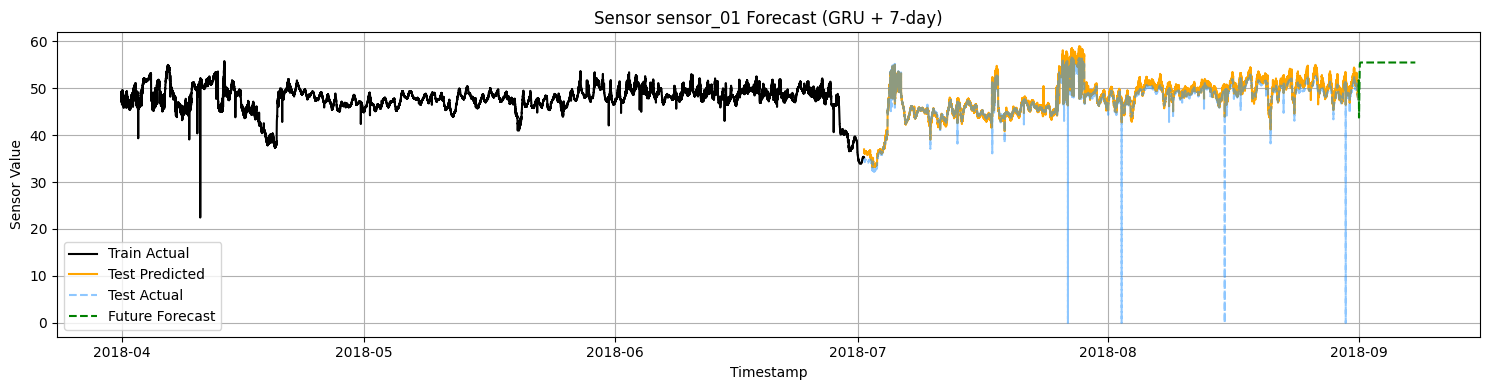

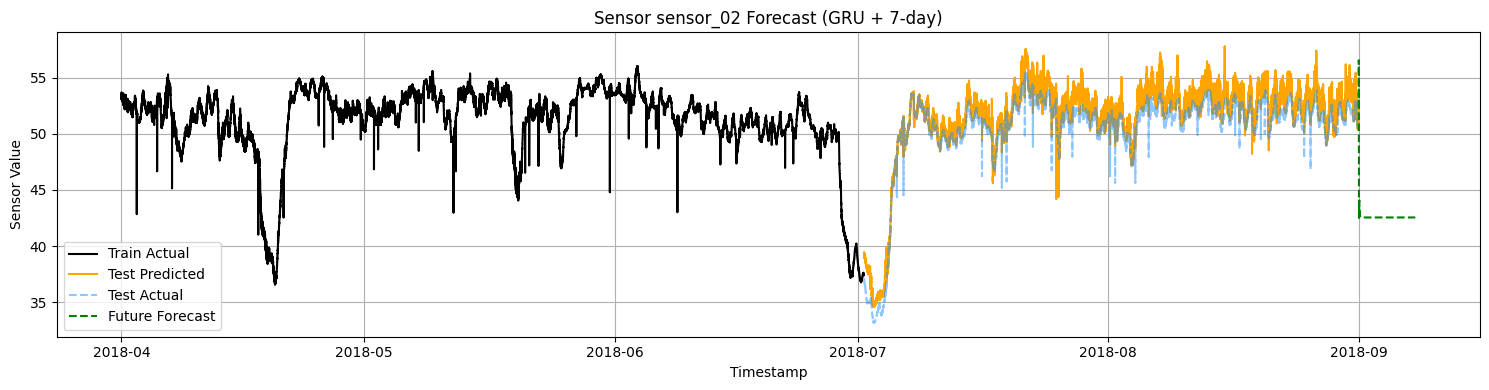

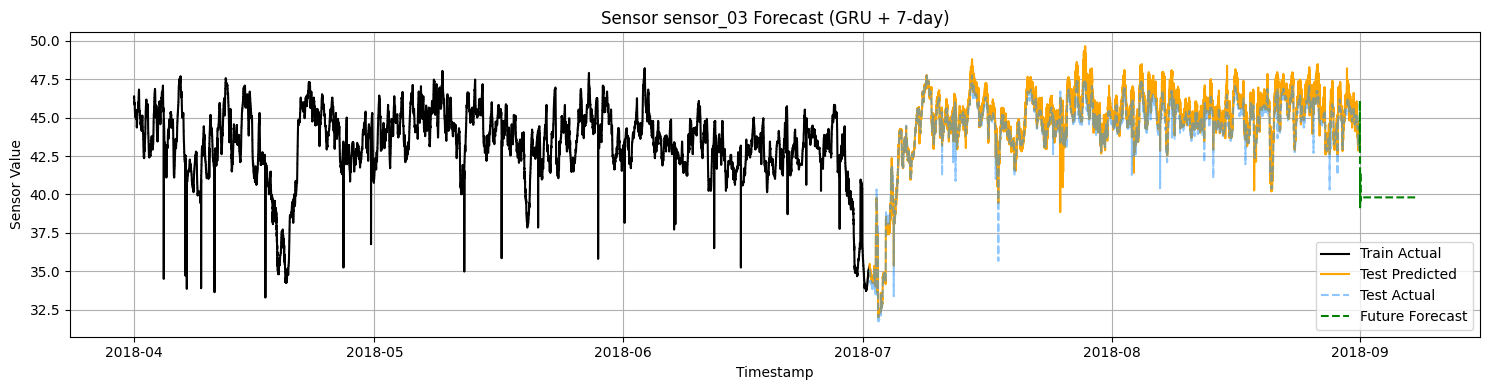

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping


data = pd.read_csv("../frontend/public/sensor.csv")

all_zero_cols = data.columns[(data == 0).all()].tolist()
all_nan_cols = data.columns[data.isna().all()].tolist()
threshold = 1.2
low_std_cols = data.std(numeric_only=True).loc[lambda x: x < threshold].index.tolist()
useless_columns = list(set(all_zero_cols + all_nan_cols + low_std_cols))
data = data.drop(columns=useless_columns)

status_map = {'NORMAL': 0, 'RECOVERING': 1, 'BROKEN': 2}
data['machine_status_encoded'] = data['machine_status'].map(status_map)

data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)
data = data.interpolate(method='time')

sensor_cols = [col for col in data.columns if col.startswith('sensor')]
scaler = StandardScaler()
data[sensor_cols] = scaler.fit_transform(data[sensor_cols])

data = data.drop(columns=['machine_status'])
data = data.sort_index()

# 학습/테스트 분할
split_index = int(len(data) * 0.6)
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

# 윈도우 생성 함수
def create_windows(df, input_steps=60, step=1):
    X, y = [], []
    values = df[sensor_cols].values
    for i in range(0, len(values) - input_steps, step):
        X.append(values[i:i+input_steps])
        y.append(values[i+input_steps])
    return np.array(X), np.array(y)

X_train, y_train = create_windows(train_data)
X_test, y_test = create_windows(test_data)

# GRU 모델 학습
model = Sequential([
    GRU(64, input_shape=X_train.shape[1:]),
    Dense(len(sensor_cols))
])
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=64, verbose=1, callbacks=[early_stop])

# 전체 테스트 구간 예측
X_init = train_data[sensor_cols].values[-60:].reshape(1, 60, len(sensor_cols))
gru_first_y_pred = model.predict(X_init)
gru_y_pred_rest = model.predict(X_test)
gru_y_pred_full = np.vstack([gru_first_y_pred, gru_y_pred_rest])

# 미래 7일 (약 10,080개) 예측
future_steps = 10080
future_preds = []
last_input = X_test[-1:].copy()

for _ in range(future_steps):
    pred = model.predict(last_input)
    future_preds.append(pred[0])
    last_input = np.append(last_input[:, 1:, :], pred.reshape(1, 1, -1), axis=1)
future_preds = np.array(future_preds)

# 역정규화
train_orig = scaler.inverse_transform(train_data[sensor_cols].values)
y_pred_orig = scaler.inverse_transform(gru_y_pred_full)
y_test_orig = scaler.inverse_transform(y_test)
future_pred_orig = scaler.inverse_transform(future_preds)

# 시간 정보 생성
time_gap = test_data.index[1] - test_data.index[0]
first_pred_time = train_data.index[-1] + time_gap
pred_timestamps = [first_pred_time + i * time_gap for i in range(len(gru_y_pred_full))]
future_timestamps = [pred_timestamps[-1] + (i + 1) * time_gap for i in range(future_steps)]

# 시각화 (3개 센서만 예시)
for i, sensor in enumerate(sensor_cols[:3]):
    plt.figure(figsize=(15, 4))
    plt.plot(train_data.index, train_orig[:, i], label="Train Actual", color='black')
    plt.plot(pred_timestamps, y_pred_orig[:, i], label="Test Predicted", color='orange')
    plt.plot(pred_timestamps[1:], y_test_orig[:, i], label="Test Actual", color='dodgerblue', linestyle='--', alpha=0.5)
    plt.plot(future_timestamps, future_pred_orig[:, i], label="Future Forecast", color='green', linestyle='--')
    plt.title(f"Sensor {sensor} Forecast (GRU + 7-day)")
    plt.xlabel("Timestamp")
    plt.ylabel("Sensor Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
